In [53]:
import os
import glob
import pandas as pd
import numpy as np

base_dir = '/Users/danielagiansante/cartbind_avg_results'
sites = ['camh', 'uhn', 'ubc']
dfs = []

for site in sites:
    site_dir = os.path.join(base_dir, site)
    csv_files = glob.glob(os.path.join(site_dir, '*.csv'))
    for csv_file in csv_files:
        # Read with row names as index, skip header if present
        df = pd.read_csv(csv_file, index_col=0)
        # Force numeric, in case any values are strings
        df = df.apply(pd.to_numeric, errors='coerce')
        dfs.append(df)

# Concatenate along axis=1 (columns), then take mean across columns for each row
all_data = pd.concat(dfs, axis=1)
mean_series = all_data.mean(axis=1, skipna=True)

# Optionally, to keep as a DataFrame with same structure (region names as index):
mean_df = mean_series.to_frame(name='mean')

# Save with row names
mean_df.to_csv(os.path.join(base_dir, 'mean_matrix.csv'))

print('Mean matrix with row names saved as mean_matrix_with_names.csv in', base_dir)

Mean matrix with row names saved as mean_matrix_with_names.csv in /Users/danielagiansante/cartbind_avg_results


In [54]:
print("Number of subject CSV files averaged:", len(dfs))

Number of subject CSV files averaged: 192


In [55]:
import pandas as pd

mean_df = pd.read_csv('/Users/danielagiansante/cartbind_avg_results/mean_matrix.csv', index_col=0)
mean_df  

,mean
lh_bankssts,0.157651
lh_caudalanteriorcingulate,0.119794
lh_caudalmiddlefrontal,0.188528
lh_cuneus,0.139247
lh_entorhinal,0.105159
...,...
rh_supramarginal,0.200987
rh_frontalpole,0.099854
rh_temporalpole,0.083054
rh_transversetemporal,0.122515


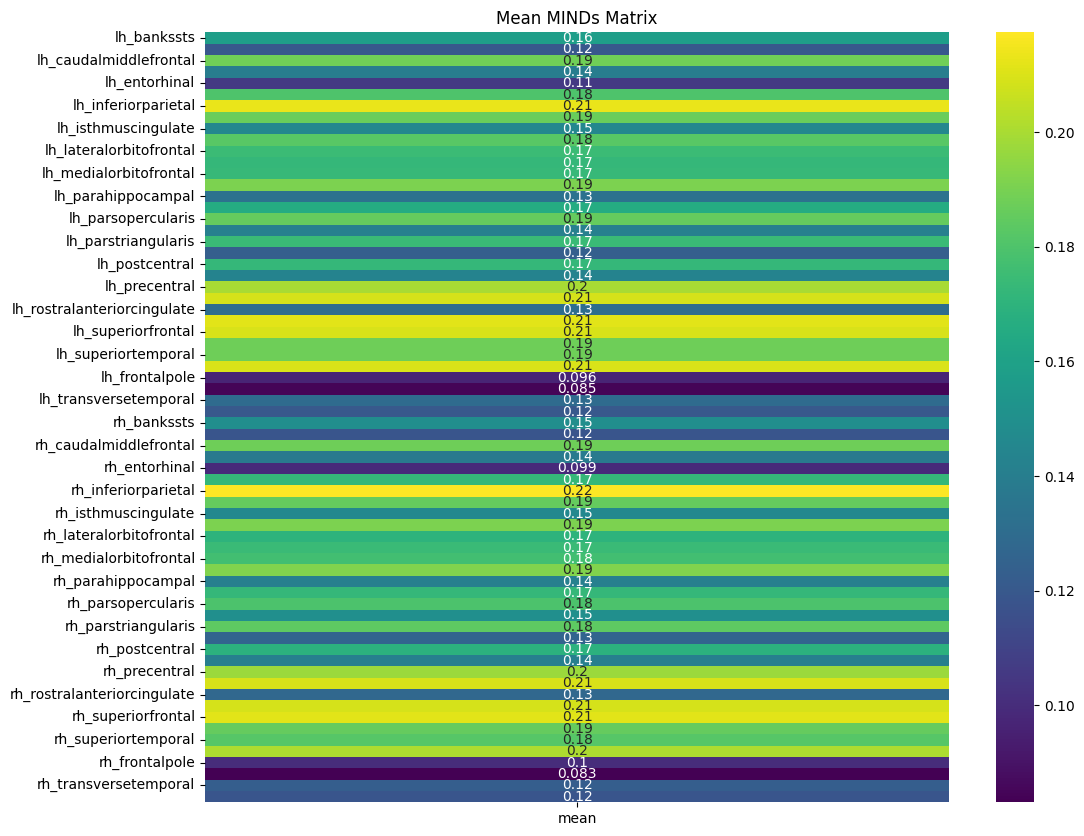

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

mean_df = pd.read_csv('/Users/danielagiansante/cartbind_avg_results/mean_matrix.csv', index_col=0)
plt.figure(figsize=(12, 10))
sns.heatmap(mean_df, cmap='viridis', annot=True)
plt.title('Mean MINDs Matrix')
plt.show()

[get_dataset_dir] Dataset found in /Users/danielagiansante/nilearn_data/fsaverage


/var/folders/jq/5tyjvtrn3ns9x6pfy351mkmw0000gn/T/ipykernel_75021/3067619559.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 0.92])


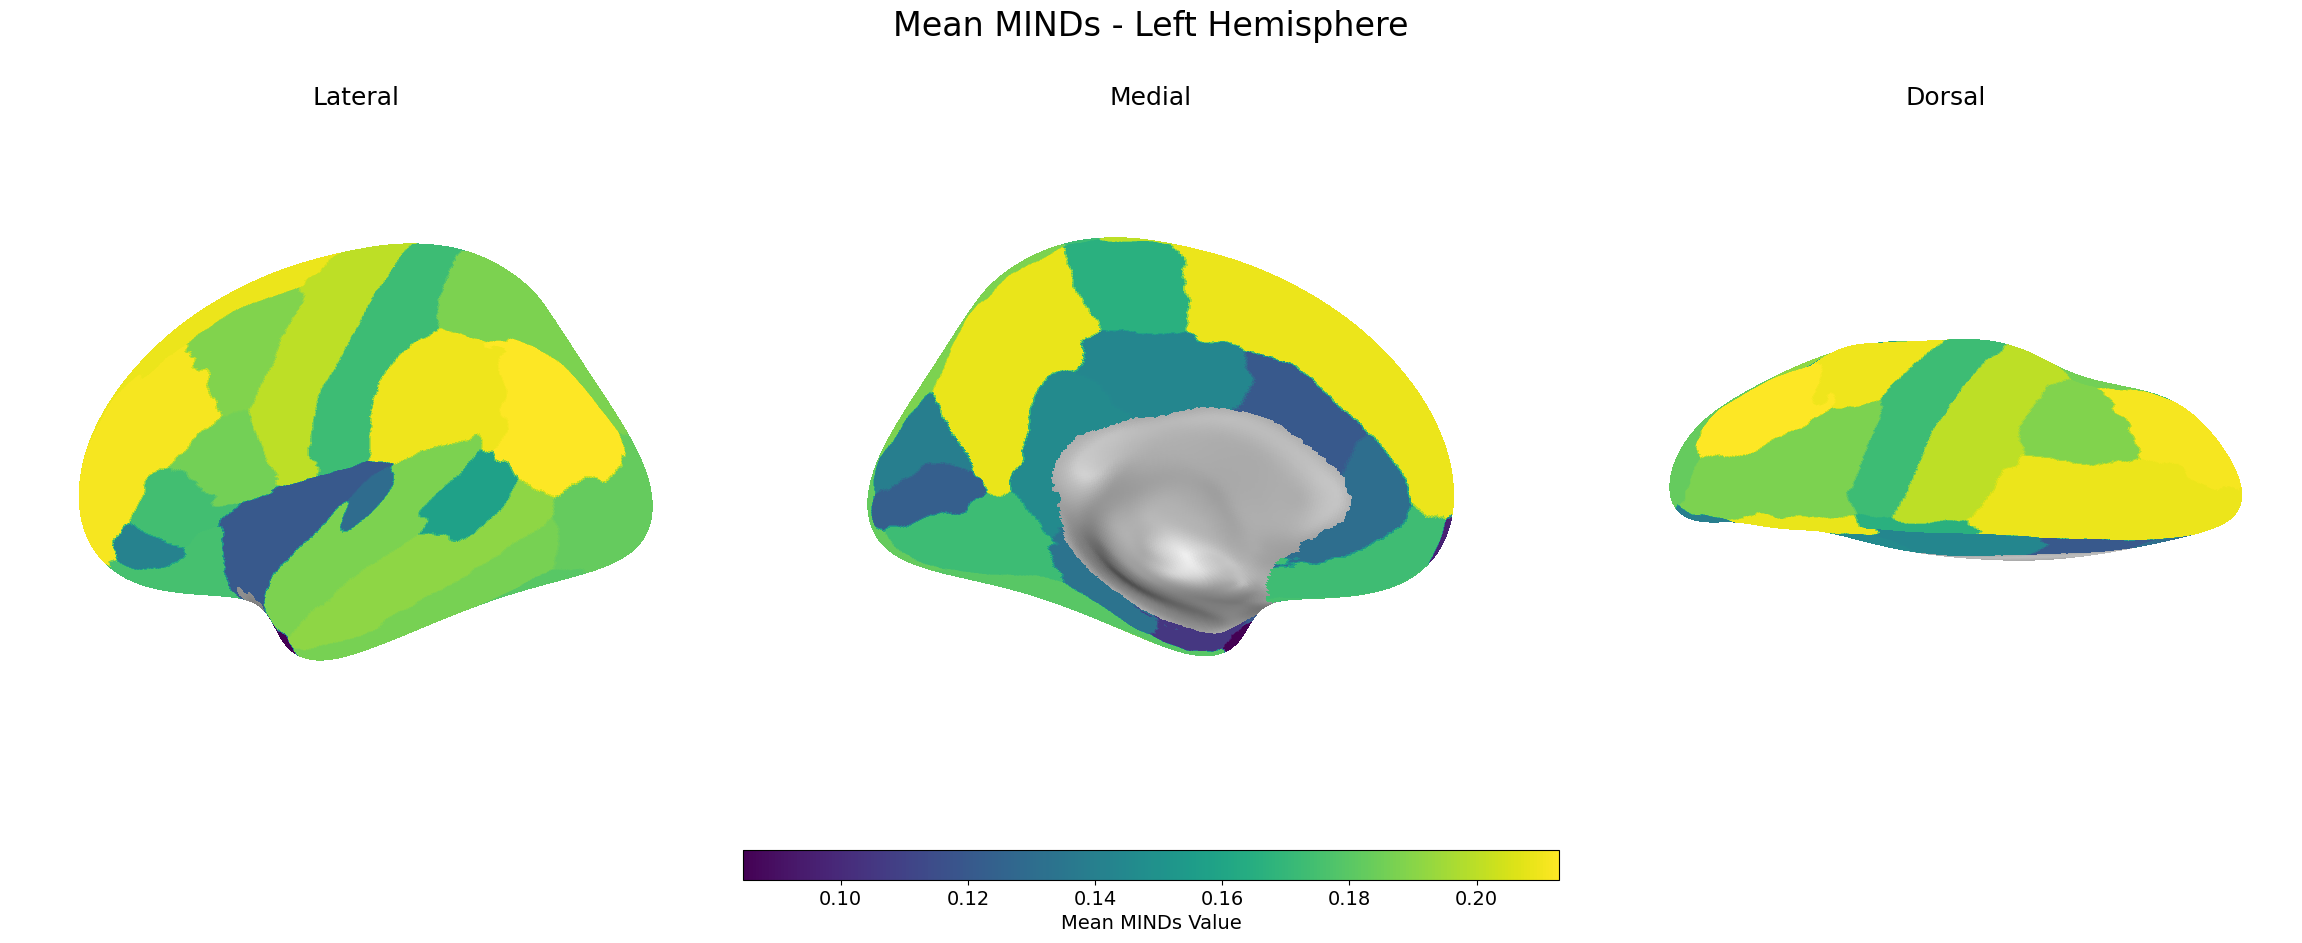

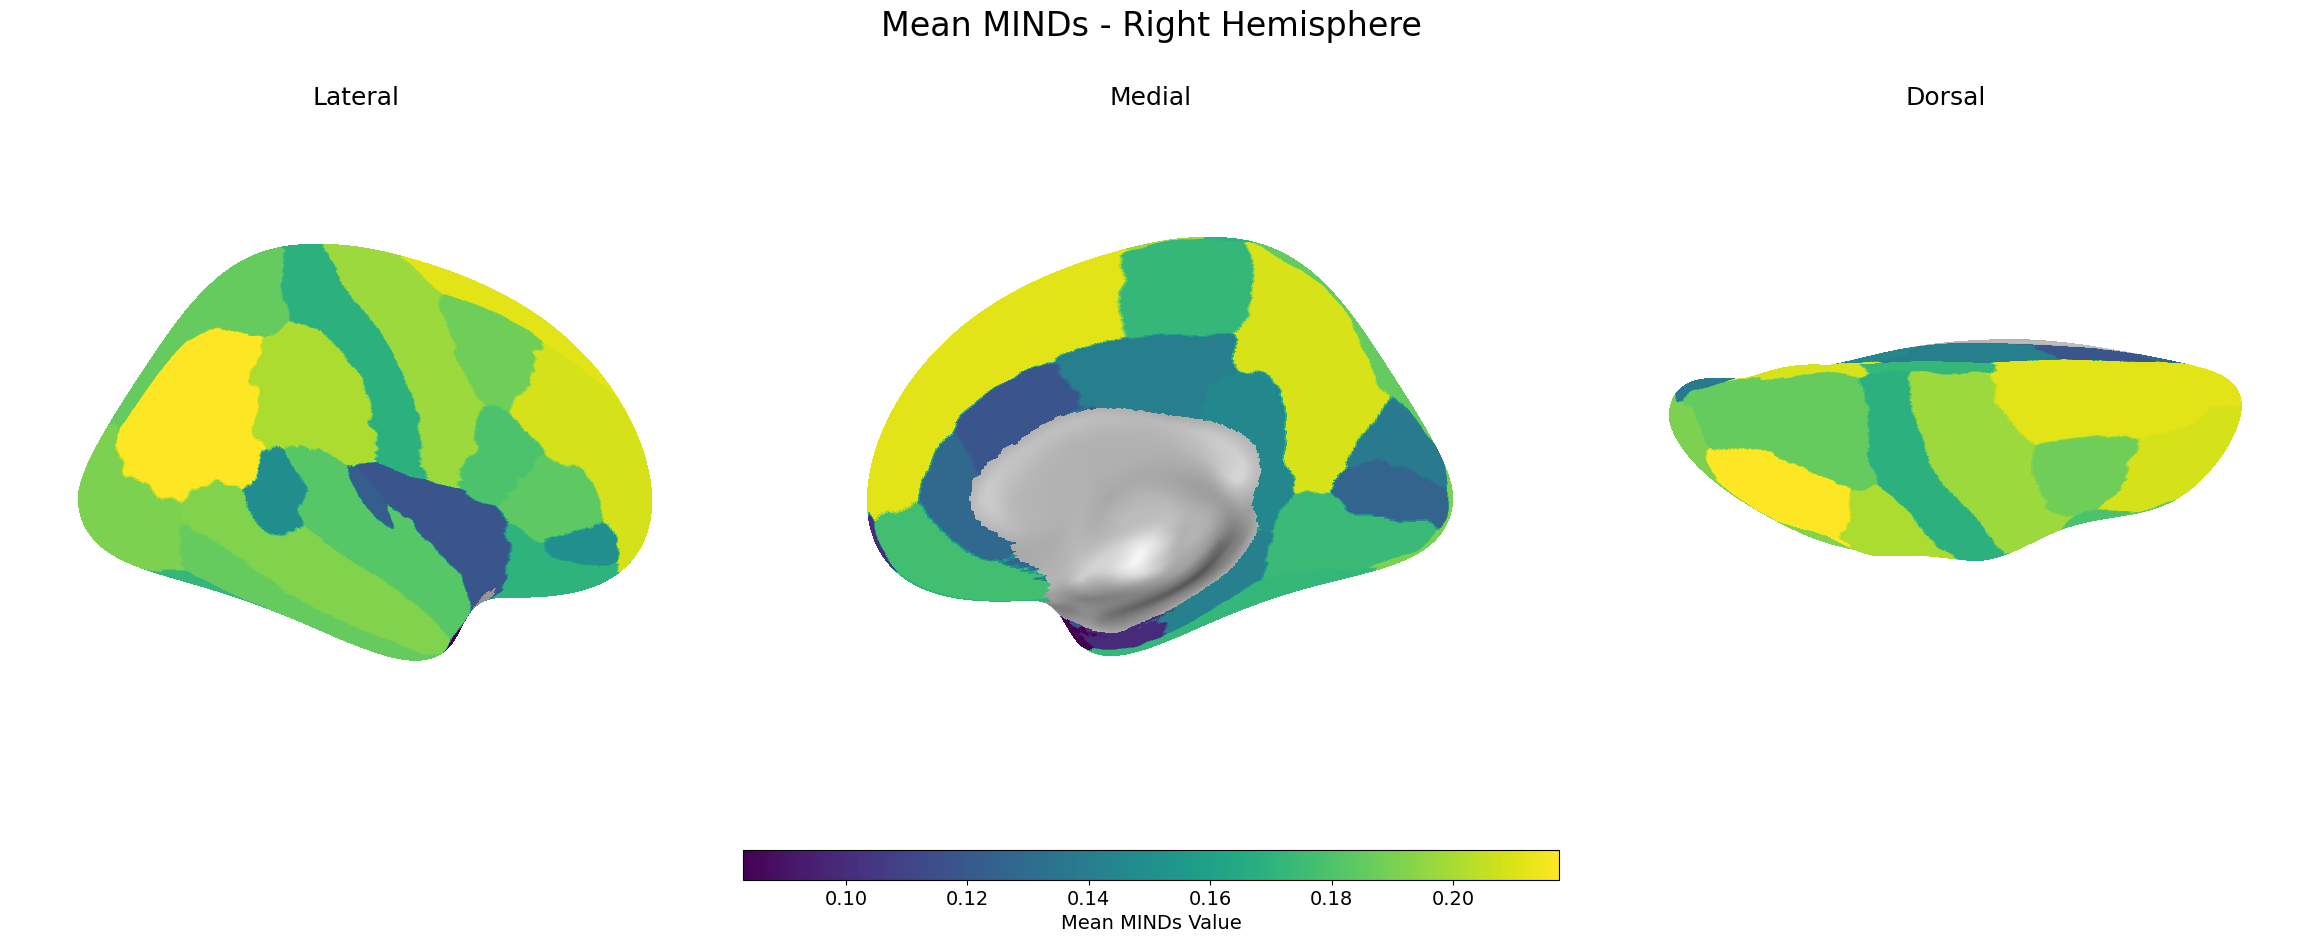

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel.freesurfer.io as fsio
from nilearn import datasets, plotting
from matplotlib import cm
from nilearn import surface


# STEP 1: Load mean matrix CSV (regions as index, one 'mean' column)
mean_df = pd.read_csv('/Users/danielagiansante/cartbind_avg_results/mean_matrix.csv', index_col=0)

# STEP 2: Set fsaverage path
fsaverage_path = '/System/Volumes/Data/Users/danielagiansante/Desktop/Installations/freesurfer/subjects/fsaverage'

# STEP 3: Load annotation files (aparc parcellation)
lh_annot = fsio.read_annot(f'{fsaverage_path}/label/lh.aparc.annot')
rh_annot = fsio.read_annot(f'{fsaverage_path}/label/rh.aparc.annot')
lh_labels, lh_cmap, lh_names = lh_annot
rh_labels, rh_cmap, rh_names = rh_annot
lh_names = [name.decode('utf-8') for name in lh_names]
rh_names = [name.decode('utf-8') for name in rh_names]

# STEP 4: Prepare vertex data arrays
lh_vertex_data = np.full_like(lh_labels, np.nan, dtype=float)
rh_vertex_data = np.full_like(rh_labels, np.nan, dtype=float)

# Helper to match region names
def region_from_var(var):
    if var.startswith('lh_'):
        return 'lh', var.replace('lh_', '')
    elif var.startswith('rh_'):
        return 'rh', var.replace('rh_', '')
    return None, None

# Map mean values to surface vertices
for var, value in mean_df['mean'].items():
    hemi, region = region_from_var(var)
    if hemi == 'lh':
        idxs = [i for i, n in enumerate(lh_names) if region.lower() == n.lower()]
        for idx in idxs:
            lh_vertex_data[lh_labels == idx] = value
    elif hemi == 'rh':
        idxs = [i for i, n in enumerate(rh_names) if region.lower() == n.lower()]
        for idx in idxs:
            rh_vertex_data[rh_labels == idx] = value

# STEP 5: Load fsaverage surfaces and sulcal maps
fsavg = datasets.fetch_surf_fsaverage('fsaverage')
lh_mesh = surface.load_surf_mesh(fsavg.infl_left)
rh_mesh = surface.load_surf_mesh(fsavg.infl_right)

sulc_left = fsavg.sulc_left
sulc_right = fsavg.sulc_right

# STEP 6: Plotting function (slightly simplified)
def plot_three_views_custom(surf_mesh, vertex_data, bg_map, hemi, title):
    views = ['lateral', 'medial', 'dorsal']
    fig, axes = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(24, 10))
    vmax = np.nanmax(vertex_data)
    vmin = np.nanmin(vertex_data)
    cmap = 'viridis'
    for i, view in enumerate(views):
        plotting.plot_surf_stat_map(
            surf_mesh, vertex_data, hemi=hemi, bg_map=bg_map,
            cmap=cmap, colorbar=False, vmax=vmax, vmin=vmin, 
            view=view, axes=axes[i], title='', figure=fig
        )
        axes[i].set_title(view.capitalize(), fontsize=18)
        axes[i].axis('off')
    # Colorbar
    cbar_ax = fig.add_axes([0.33, 0.09, 0.34, 0.03])
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, orientation='horizontal')
    cb.set_label('Mean MINDs Value', fontsize=14)
    cb.ax.tick_params(labelsize=14)
    plt.suptitle(title, fontsize=24, y=0.96)
    plt.tight_layout(rect=[0, 0.15, 1, 0.92])
    plt.show()

# STEP 7: Plot for both hemispheres
plot_three_views_custom(lh_mesh, lh_vertex_data, sulc_left, 'left', 'Mean MINDs - Left Hemisphere')
plot_three_views_custom(rh_mesh, rh_vertex_data, sulc_right, 'right', 'Mean MINDs - Right Hemisphere')

In [58]:
# PREDICTIVE MODELLING WITH THE AVERAGE MATRIX

In [59]:
#Step 1: getting the dataset ready 
    #merging all the matrices together 

import pandas as pd
import glob
import os

root_dir = '/Users/danielagiansante/cartbind_avg_results'
csv_files = glob.glob(os.path.join(root_dir, '*', '*_aparc_MIND_matrix.csv'))

data = []
subject_ids = []
sites = []

for file in csv_files:
    # Extract subject ID from filename (e.g. sub-098 from sub-098_aparc_MIND_matrix.csv)
    subj_id = os.path.basename(file).split('_')[0]
    # Extract site from the directory
    site = os.path.basename(os.path.dirname(file))
    df = pd.read_csv(file, sep=None, engine='python')
    df = df.set_index(df.columns[0])
    # Use 'average' column if present, otherwise first column
    if "average" in df.columns:
        row = df["average"].to_list()
    else:
        row = df.iloc[:,0].to_list()
    data.append(row)
    subject_ids.append(subj_id)
    sites.append(site)

# Use the index from the first file as column names
region_names = pd.read_csv(csv_files[0], sep=None, engine='python').iloc[:,0].to_list()

# Create combined DataFrame
combined_df = pd.DataFrame(data, columns=region_names)
combined_df.insert(0, 'site', sites)
combined_df.insert(0, 'subject', subject_ids)

# Save to CSV
combined_df.to_csv('combined_aparc_matrix_with_site.csv', index=False)

In [60]:
import pandas as pd

dataset = pd.read_csv('/Users/danielagiansante/CARTBIND/UTF-82025_04_Zhukovsky_CARTBIND_summary_unblinded.csv')

# 1. Extract subject number and site to match combined_df format
def extract_subj_site(row):
    subj_id = row.split('_')[-1]  # e.g., '002'
    site_raw = row.split('_')[1].lower()  # e.g., 'CAM'/'UHN'/'UBC'
    site_map = {'cam': 'camh', 'uhn': 'uhn', 'ubc': 'ubc'}
    site = site_map.get(site_raw, site_raw)
    return pd.Series([f"sub-{int(subj_id):03d}", site])

dataset[['subject', 'site']] = dataset['Subject_ID'].apply(extract_subj_site)

# 2. Create response column
dataset['response'] = dataset[['hrsd_resp_t30', 'hrsd_resp_t25', 'hrsd_resp_t20',
                              'hrsd_resp_t15', 'hrsd_resp_t10']].bfill(axis=1).iloc[:, 0]

# Merge 
merged_df = combined_df.merge(dataset[['subject', 'site', 'response']], on=['subject', 'site'], how='left')

# Save or check your merged dataframe
merged_df.to_csv('combined_aparc_matrix_with_response.csv', index=False)
print(merged_df[['subject', 'site', 'response']].head())


   subject site  response
0  sub-041  uhn       0.0
1  sub-057  uhn       0.0
2  sub-039  uhn       1.0
3  sub-015  uhn       NaN
4  sub-003  uhn       0.0


In [61]:
merged_df

,subject,site,lh_bankssts,lh_caudalanteriorcingulate,lh_caudalmiddlefrontal,lh_cuneus,lh_entorhinal,lh_fusiform,lh_inferiorparietal,lh_inferiortemporal,...,rh_rostralmiddlefrontal,rh_superiorfrontal,rh_superiorparietal,rh_superiortemporal,rh_supramarginal,rh_frontalpole,rh_temporalpole,rh_transversetemporal,rh_insula,response
0,sub-041,uhn,0.166099,0.129928,0.202584,0.137972,0.136537,0.199687,0.218849,0.197477,...,0.234003,0.229044,0.202814,0.202523,0.205810,0.117086,0.099065,0.129692,0.130712,0.0
1,sub-057,uhn,0.181821,0.122996,0.214347,0.175041,0.091120,0.196002,0.234913,0.193704,...,0.230282,0.239010,0.204466,0.218048,0.225917,0.100629,0.082561,0.129937,0.123667,0.0
2,sub-039,uhn,0.143485,0.124433,0.183672,0.156529,0.107476,0.173408,0.211542,0.179773,...,0.212657,0.203353,0.182383,0.188396,0.199115,0.098145,0.081392,0.122894,0.137490,1.0
3,sub-015,uhn,0.165384,0.127321,0.173184,0.138166,0.107736,0.171661,0.204705,0.172651,...,0.200111,0.224244,0.191751,0.184968,0.211588,0.103400,0.073103,0.122012,0.130206,NaN
4,sub-003,uhn,0.157463,0.133511,0.190370,0.156820,0.094222,0.187686,0.219976,0.192932,...,0.217815,0.224261,0.198123,0.192111,0.201582,0.100948,0.087683,0.120991,0.121452,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,sub-123,camh,0.145483,0.113365,0.179333,0.130299,0.089965,0.178735,0.199292,0.180525,...,0.203662,0.192012,0.183043,0.160560,0.179476,0.102540,0.075048,0.124318,0.117532,1.0
188,sub-020,camh,0.158060,0.134058,0.214410,0.143801,0.100799,0.193239,0.219353,0.202364,...,0.237579,0.235408,0.211035,0.200372,0.212888,0.108382,0.079326,0.135619,0.123809,1.0
189,sub-096,camh,0.144480,0.117222,0.183607,0.143294,0.097745,0.169552,0.197460,0.172870,...,0.198388,0.193327,0.184722,0.174479,0.183498,0.096268,0.082221,0.113083,0.113536,0.0
190,sub-058,camh,0.183868,0.109435,0.192925,0.135011,0.096324,0.177137,0.218249,0.166348,...,0.217749,0.207307,0.198695,0.179686,0.195292,0.092852,0.088447,0.140403,0.114165,0.0


In [62]:
print(f"Original number of subjects: {len(merged_df)}")

# Drop rows with any missing values 
clean_df = merged_df.dropna(subset=['response'])

print(f"Number of subjects after dropping missing response: {len(clean_df)}")

# Note to self: For the predictive modelling the dataset name is called 'clean_df'

Original number of subjects: 192
Number of subjects after dropping missing response: 177


In [63]:
#Setting up for logistic regression 

import pandas as pd
import numpy as np
import re

# Step 1: Define initial predictors
X = clean_df[['lh_bankssts', 'lh_caudalanteriorcingulate',
       'lh_caudalmiddlefrontal', 'lh_cuneus', 'lh_entorhinal', 'lh_fusiform',
       'lh_inferiorparietal', 'lh_inferiortemporal', 'lh_isthmuscingulate',
       'lh_lateraloccipital', 'lh_lateralorbitofrontal', 'lh_lingual',
       'lh_medialorbitofrontal', 'lh_middletemporal', 'lh_parahippocampal',
       'lh_paracentral', 'lh_parsopercularis', 'lh_parsorbitalis',
       'lh_parstriangularis', 'lh_pericalcarine', 'lh_postcentral',
       'lh_posteriorcingulate', 'lh_precentral', 'lh_precuneus',
       'lh_rostralanteriorcingulate', 'lh_rostralmiddlefrontal',
       'lh_superiorfrontal', 'lh_superiorparietal', 'lh_superiortemporal',
       'lh_supramarginal', 'lh_frontalpole', 'lh_temporalpole',
       'lh_transversetemporal', 'lh_insula', 'rh_bankssts',
       'rh_caudalanteriorcingulate', 'rh_caudalmiddlefrontal', 'rh_cuneus',
       'rh_entorhinal', 'rh_fusiform', 'rh_inferiorparietal',
       'rh_inferiortemporal', 'rh_isthmuscingulate', 'rh_lateraloccipital',
       'rh_lateralorbitofrontal', 'rh_lingual', 'rh_medialorbitofrontal',
       'rh_middletemporal', 'rh_parahippocampal', 'rh_paracentral',
       'rh_parsopercularis', 'rh_parsorbitalis', 'rh_parstriangularis',
       'rh_pericalcarine', 'rh_postcentral', 'rh_posteriorcingulate',
       'rh_precentral', 'rh_precuneus', 'rh_rostralanteriorcingulate',
       'rh_rostralmiddlefrontal', 'rh_superiorfrontal', 'rh_superiorparietal',
       'rh_superiortemporal', 'rh_supramarginal', 'rh_frontalpole',
       'rh_temporalpole', 'rh_transversetemporal', 'rh_insula']]

y = clean_df['response']



=== Threshold: 0.4 ===
Combined Confusion Matrix:
 [[48 60]
 [23 46]]
Mean Accuracy: 0.5307189542483661
Mean Sensitivity: 0.6642857142857143
Mean Specificity: 0.4445454545454545

=== Threshold: 0.5 ===
Combined Confusion Matrix:
 [[59 49]
 [30 39]]
Mean Accuracy: 0.5529411764705883
Mean Sensitivity: 0.5619047619047619
Mean Specificity: 0.5454545454545455

=== Threshold: 0.6 ===
Combined Confusion Matrix:
 [[79 29]
 [41 28]]
Mean Accuracy: 0.6049019607843138
Mean Sensitivity: 0.40476190476190477
Mean Specificity: 0.7318181818181818

=== Threshold: 0.7 ===
Combined Confusion Matrix:
 [[89 19]
 [48 21]]
Mean Accuracy: 0.6215686274509804
Mean Sensitivity: 0.3047619047619047
Mean Specificity: 0.8236363636363636

=== Threshold: 0.75 ===
Combined Confusion Matrix:
 [[92 16]
 [51 18]]
Mean Accuracy: 0.6212418300653595
Mean Sensitivity: 0.2595238095238095
Mean Specificity: 0.850909090909091

=== Threshold: 0.8 ===
Combined Confusion Matrix:
 [[92 16]
 [53 16]]
Mean Accuracy: 0.6098039215686274

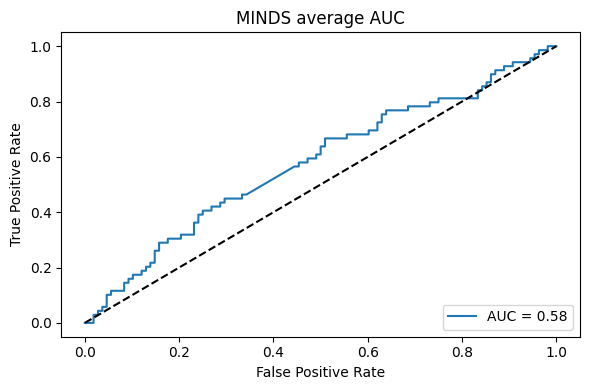

In [64]:
#Running logistic regression
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

all_y_true_average = []
all_y_prob_average = []

thresholds = [0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85]
results = {t: {'cm': np.zeros((2, 2), dtype=int), 'sens': [], 'spec': [], 'acc': []} for t in thresholds}

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

surviving_vars_per_fold = []
coefs_list = []

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = make_pipeline(
        StandardScaler(),
        LogisticRegressionCV(
            penalty='elasticnet',
            solver='saga',
            l1_ratios=[0.6],
            Cs=[0.001, 0.01, 0.1, 1, 10, 100],
            max_iter=8000,
            class_weight='balanced',
            random_state=42,
            cv=10
        )
    )

    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    all_y_true_average.extend(y_test)
    all_y_prob_average.extend(y_prob)

    # Get coefficients from logisticregressioncv step
    coefs = model.named_steps['logisticregressioncv'].coef_.ravel()
    coefs_list.append(coefs)
    surviving = [name for name, coef in zip(X.columns, coefs) if coef != 0]
    surviving_vars_per_fold.append(surviving)

    #Confusion matrix and metrics calculation for each threshold
    for threshold in thresholds:
        y_pred_custom = (y_prob >= threshold).astype(int)
        cm = confusion_matrix(y_test, y_pred_custom)
        results[threshold]['cm'] += cm
        results[threshold]['acc'].append(accuracy_score(y_test, y_pred_custom))
        results[threshold]['sens'].append(recall_score(y_test, y_pred_custom))
        TN, FP = cm[0]
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        results[threshold]['spec'].append(specificity)

# Print average metrics for each threshold
for threshold in thresholds:
    print(f"\n=== Threshold: {threshold} ===")
    print("Combined Confusion Matrix:\n", results[threshold]['cm'])
    print("Mean Accuracy:", np.mean(results[threshold]['acc']))
    print("Mean Sensitivity:", np.mean(results[threshold]['sens']))
    print("Mean Specificity:", np.mean(results[threshold]['spec']))

# Calculate AUC across all folds
auc_average = roc_auc_score(all_y_true_average, all_y_prob_average)
print("MINDS average AUC:", auc_average)

#Plotting AUC
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr_average, tpr_average, _ = roc_curve(all_y_true_average, all_y_prob_average)
plt.figure(figsize=(6, 4))
plt.plot(fpr_average, tpr_average, label=f"AUC = {auc_average:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("MINDS average AUC")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [65]:
best_c = model.named_steps['logisticregressioncv'].C_[0]
best_l1 = model.named_steps['logisticregressioncv'].l1_ratio_
print(f"Best C for this fold: {best_c}")
print(f"Best l1_ratio for this fold: {best_l1}")

Best C for this fold: 1.0
Best l1_ratio for this fold: [0.6]



Number of folds each variable survived:
lh_bankssts: 7 / 10 folds
lh_caudalanteriorcingulate: 5 / 10 folds
lh_caudalmiddlefrontal: 7 / 10 folds
lh_cuneus: 6 / 10 folds
lh_entorhinal: 8 / 10 folds
lh_fusiform: 8 / 10 folds
lh_inferiorparietal: 8 / 10 folds
lh_inferiortemporal: 9 / 10 folds
lh_isthmuscingulate: 6 / 10 folds
lh_lateraloccipital: 4 / 10 folds
lh_lateralorbitofrontal: 9 / 10 folds
lh_lingual: 8 / 10 folds
lh_medialorbitofrontal: 8 / 10 folds
lh_middletemporal: 9 / 10 folds
lh_parahippocampal: 9 / 10 folds
lh_paracentral: 4 / 10 folds
lh_parsopercularis: 8 / 10 folds
lh_parsorbitalis: 7 / 10 folds
lh_parstriangularis: 9 / 10 folds
lh_pericalcarine: 9 / 10 folds
lh_postcentral: 6 / 10 folds
lh_posteriorcingulate: 9 / 10 folds
lh_precentral: 8 / 10 folds
lh_precuneus: 8 / 10 folds
lh_rostralanteriorcingulate: 9 / 10 folds
lh_rostralmiddlefrontal: 8 / 10 folds
lh_superiorfrontal: 8 / 10 folds
lh_superiorparietal: 5 / 10 folds
lh_superiortemporal: 7 / 10 folds
lh_supramarginal:

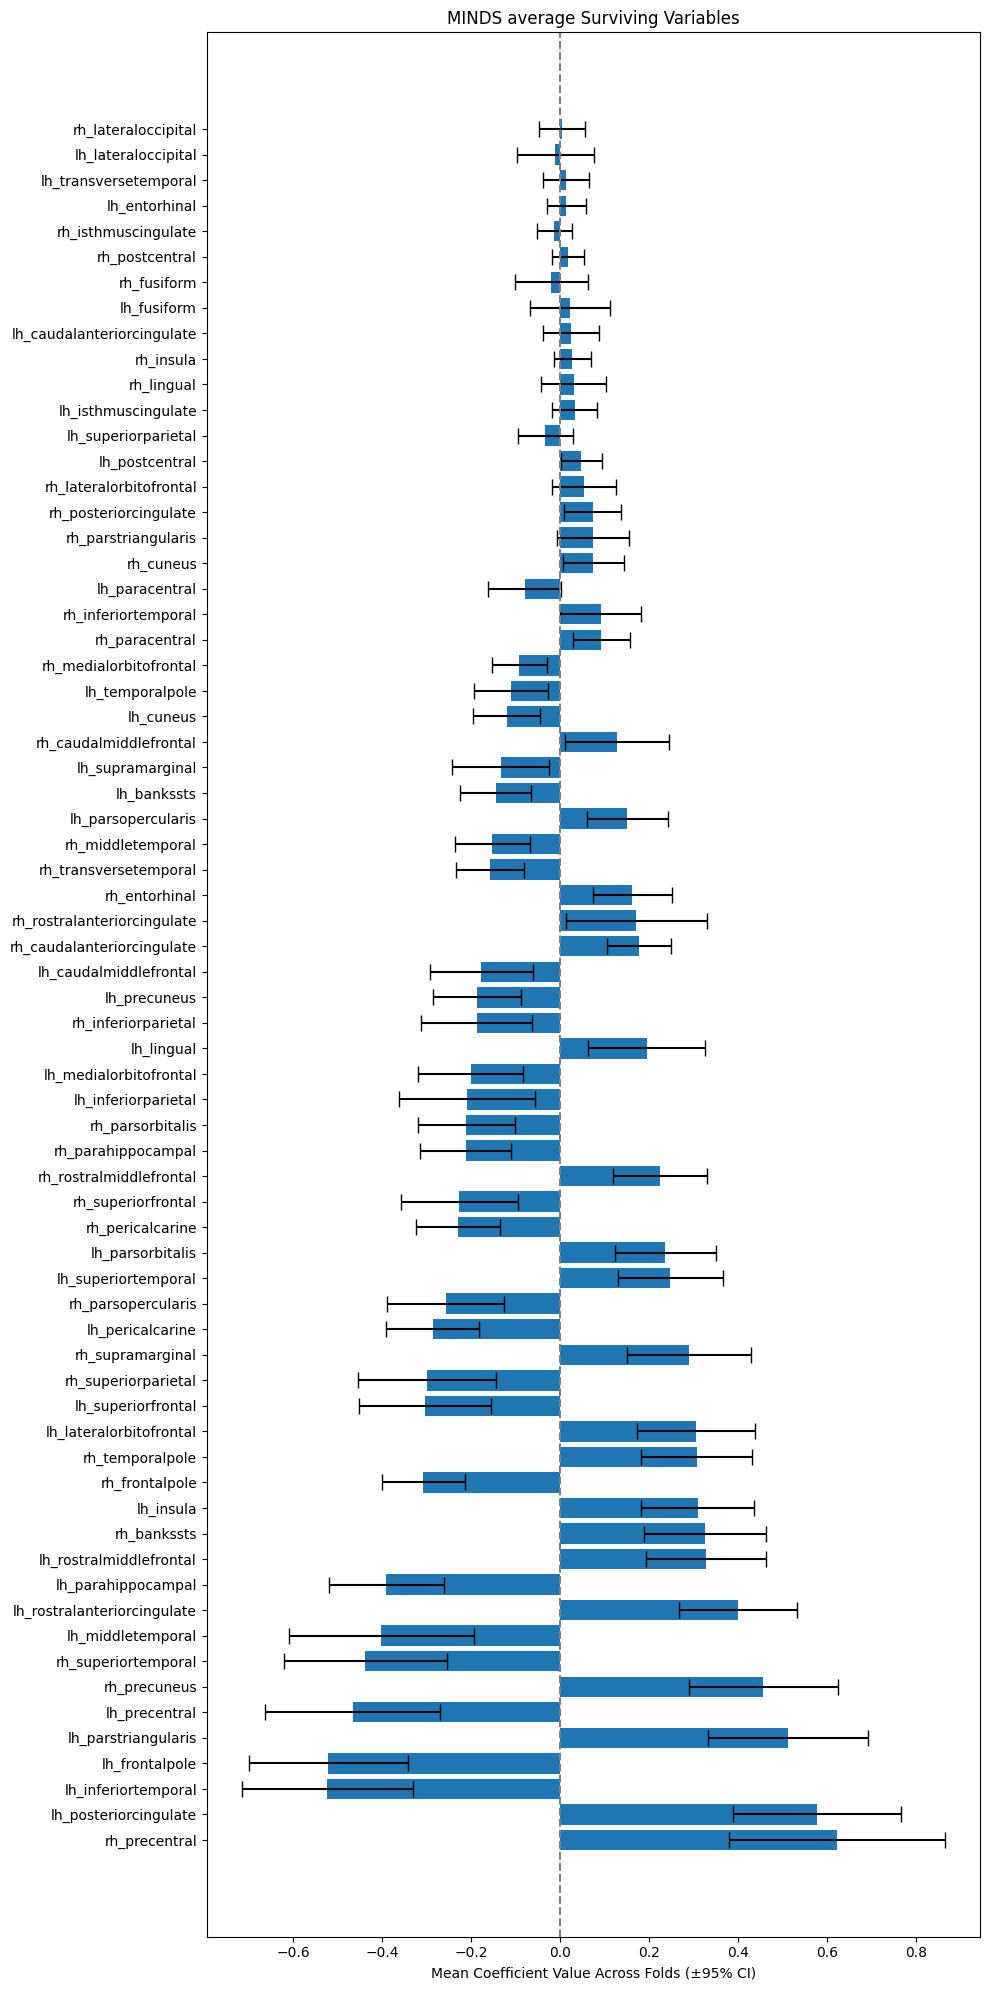

In [66]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt


# 1. Print summary of variable survival across folds
flat_survivors = [item for sublist in surviving_vars_per_fold for item in sublist]
survivor_counts = Counter(flat_survivors)
print("\nNumber of folds each variable survived:")
for var, count in survivor_counts.items():
    print(f"{var}: {count} / {skf.get_n_splits()} folds")

print("\nVariables surviving in >50% of folds:")
for var, count in survivor_counts.items():
    if count > skf.get_n_splits() / 2:
        print(var)

print("\nVariables surviving in ALL folds:")
for var, count in survivor_counts.items():
    if count == skf.get_n_splits():
        print(var)

# 2. Aggregate  
coefs_array = np.array(coefs_list)  # shape: (n_folds, n_features)
mean_coefs = coefs_array.mean(axis=0)
std_coefs = coefs_array.std(axis=0, ddof=1)
n_folds = coefs_array.shape[0]
ci95 = 1.96 * std_coefs / np.sqrt(n_folds)  # 95% confidence interval

# 3. Identify surviving (nonzero) variables and plot
surviving_mask = np.any(coefs_array != 0, axis=0)
surviving_vars = np.array(X.columns)[surviving_mask]

print("\nSurviving variables (non-zero in at least one fold):")
print(surviving_vars.tolist())
print("Mean coefficients for surviving variables:")
print(mean_coefs[surviving_mask])

print("95% CI for each surviving variable:")
for name, mean, ci in zip(surviving_vars, mean_coefs[surviving_mask], ci95[surviving_mask]):
    print(f"{name}: {mean:.3f} ± {ci:.3f}")

# 4. Plot (only surviving variables for clarity)
if len(surviving_vars) == 0:
    print("No surviving variables to plot.")
else:
    mean_surv = mean_coefs[surviving_mask]
    ci95_surv = ci95[surviving_mask]
    sorted_idx = np.argsort(np.abs(mean_surv))[::-1]
    plt.figure(figsize=(10, 20))
    plt.barh(
        y=surviving_vars[sorted_idx],
        width=mean_surv[sorted_idx],
        xerr=ci95_surv[sorted_idx],
        capsize=6,
        ecolor="black",
        linewidth=2
    )
    plt.xlabel("Mean Coefficient Value Across Folds (±95% CI)")
    plt.title("MINDS average Surviving Variables")
    plt.axvline(0, color='grey', linestyle='--')
    plt.tight_layout()
    plt.show()

In [67]:
# After calculating mean_coefs and ci95

# For surviving variables only
means = mean_coefs[surviving_mask]
cis = ci95[surviving_mask]
names = surviving_vars

# CI does not cross zero if lower bound and upper bound have the same sign (and are not zero)
lower = means - cis
upper = means + cis
no_cross_zero_mask = (lower > 0) | (upper < 0)

survivors_no_cross_zero_average = names[no_cross_zero_mask]

print("Number of variables whose 95% CI does NOT cross zero:", no_cross_zero_mask.sum())
print("\nSurviving variables whose 95% CI does NOT cross 0:")
for name, mean, lo, hi in zip(names[no_cross_zero_mask], means[no_cross_zero_mask], lower[no_cross_zero_mask], upper[no_cross_zero_mask]):
    print(f"{name}: mean={mean:.3f}, 95% CI= [{lo:.3f}, {hi:.3f}]")

Number of variables whose 95% CI does NOT cross zero: 52

Surviving variables whose 95% CI does NOT cross 0:
lh_bankssts: mean=-0.146, 95% CI= [-0.225, -0.066]
lh_caudalmiddlefrontal: mean=-0.177, 95% CI= [-0.294, -0.061]
lh_cuneus: mean=-0.121, 95% CI= [-0.197, -0.045]
lh_inferiorparietal: mean=-0.210, 95% CI= [-0.362, -0.058]
lh_inferiortemporal: mean=-0.523, 95% CI= [-0.716, -0.331]
lh_lateralorbitofrontal: mean=0.305, 95% CI= [0.173, 0.438]
lh_lingual: mean=0.194, 95% CI= [0.062, 0.325]
lh_medialorbitofrontal: mean=-0.202, 95% CI= [-0.320, -0.083]
lh_middletemporal: mean=-0.402, 95% CI= [-0.610, -0.195]
lh_parahippocampal: mean=-0.391, 95% CI= [-0.520, -0.263]
lh_parsopercularis: mean=0.150, 95% CI= [0.059, 0.242]
lh_parsorbitalis: mean=0.236, 95% CI= [0.122, 0.349]
lh_parstriangularis: mean=0.512, 95% CI= [0.332, 0.692]
lh_pericalcarine: mean=-0.287, 95% CI= [-0.391, -0.183]
lh_postcentral: mean=0.047, 95% CI= [0.000, 0.095]
lh_posteriorcingulate: mean=0.577, 95% CI= [0.389, 0.765


AUC for MINDS average strict surviving variables: 0.685


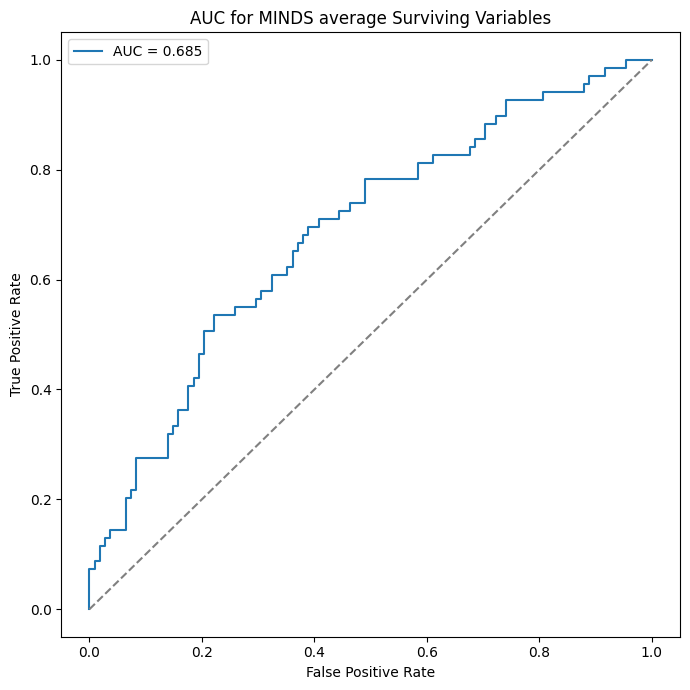

In [68]:
#Re Running Logistic Regression with MINDS average surviving variables where CI dont cross 0
import numpy as np
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Prepare data using only strict surviving variables 
X_average = X[survivors_no_cross_zero_average]

#  Re-run cross-validated logistic regression 
all_y_truestrict_average = []
all_y_probstrict_average = []

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for train_idx, test_idx in skf.split(X_average, y):
    X_train, X_test = X_average.iloc[train_idx], X_average.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    model = make_pipeline(
        StandardScaler(),
        LogisticRegressionCV(
            penalty='elasticnet',
            solver='saga',
            l1_ratios=[0.6],
            Cs=[0.001, 0.01, 0.1, 1, 10, 100],
            max_iter=8000,
            class_weight='balanced',
            random_state=42,
            cv=10
        )
    )
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    all_y_truestrict_average.extend(y_test)
    all_y_probstrict_average.extend(y_prob)

aucstrict_average = roc_auc_score(all_y_truestrict_average, all_y_probstrict_average)
print(f"\nAUC for MINDS average strict surviving variables: {aucstrict_average:.3f}")

# Plot ROC Curve 
fprstrict_average, tprstrict_average, _ = roc_curve(all_y_truestrict_average, all_y_probstrict_average)
plt.figure(figsize=(7,7))
plt.plot(fprstrict_average, tprstrict_average, label=f'AUC = {aucstrict_average:.3f}')
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'AUC for MINDS average Surviving Variables')
plt.legend()
plt.tight_layout()
plt.show()

[get_dataset_dir] Dataset found in /Users/danielagiansante/nilearn_data/fsaverage


/var/folders/jq/5tyjvtrn3ns9x6pfy351mkmw0000gn/T/ipykernel_75021/3326568138.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 0.92])


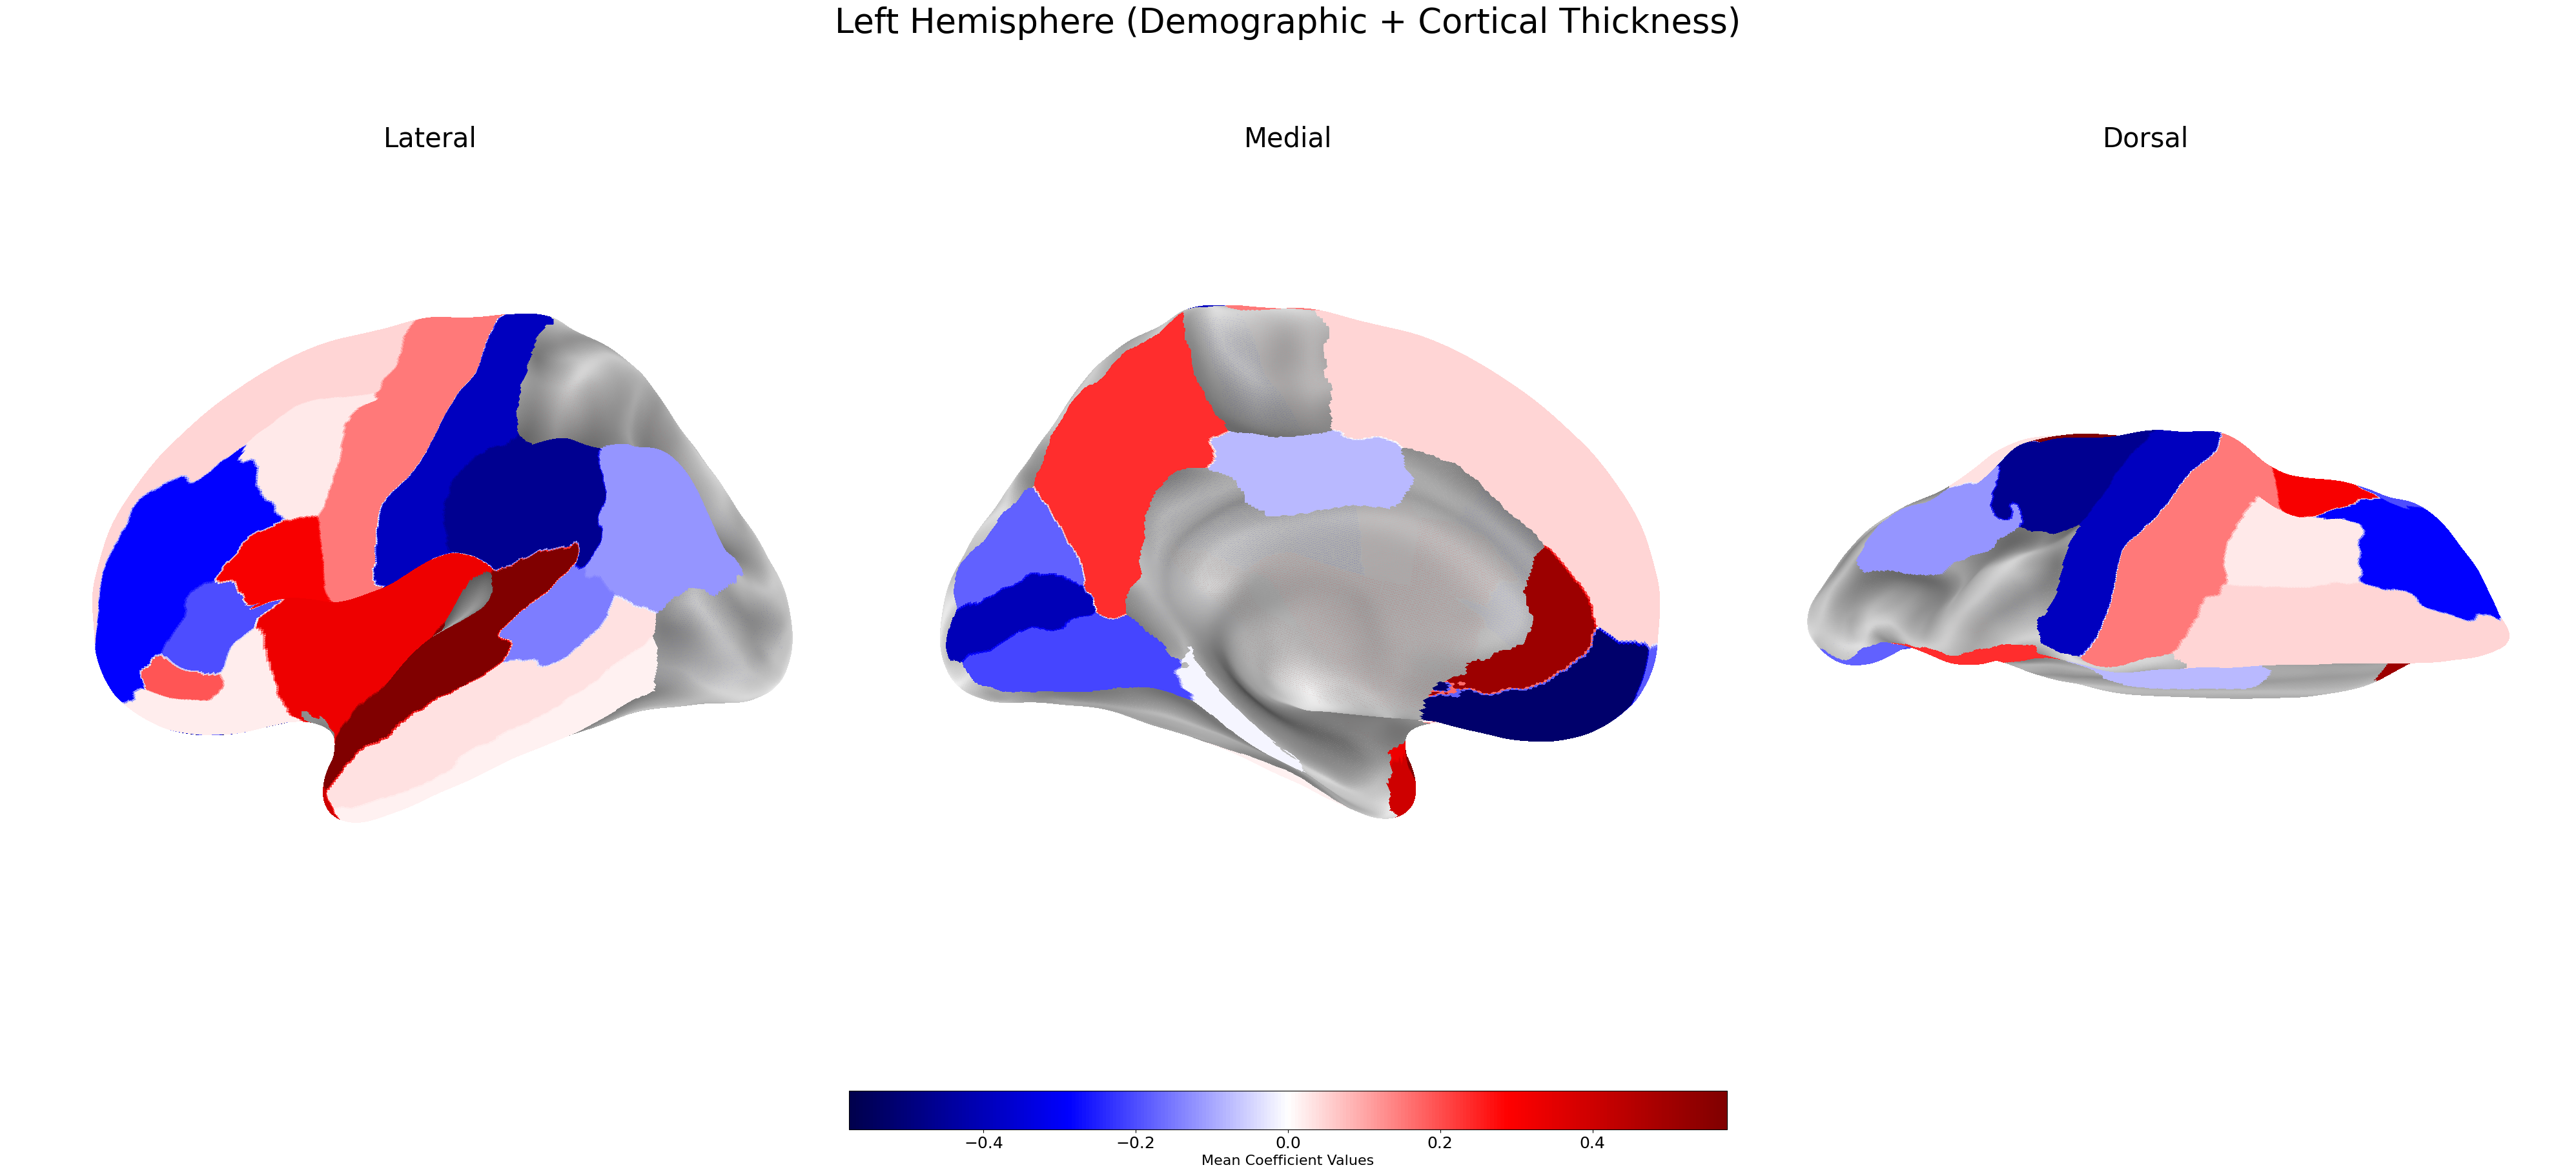

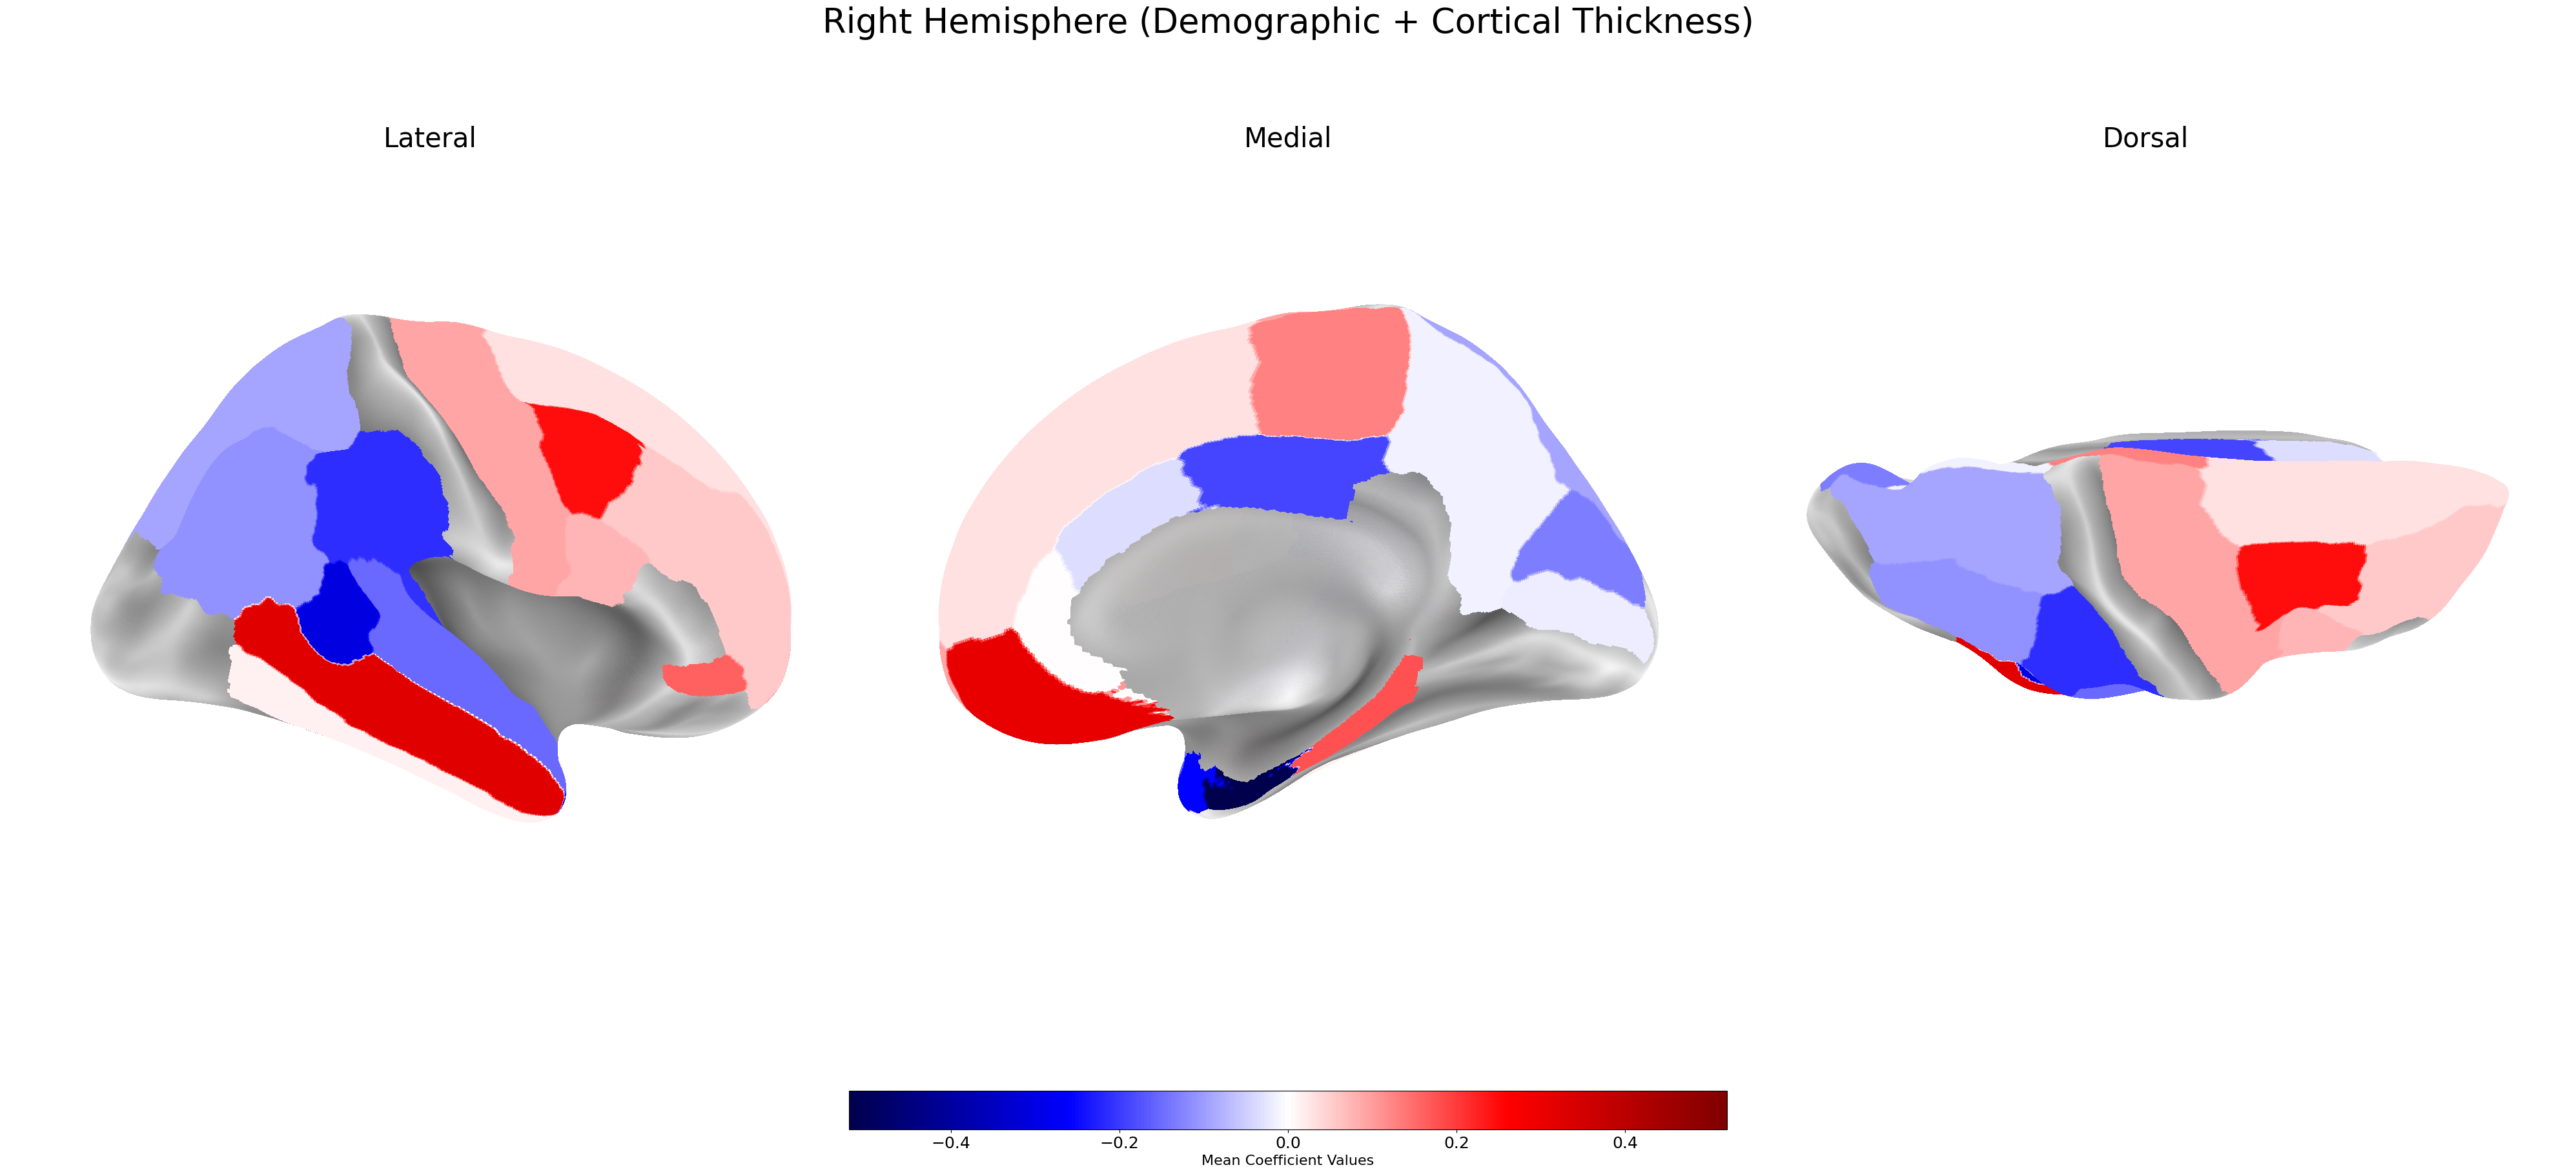

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel.freesurfer.io as fsio
from nilearn import datasets, plotting
from matplotlib import cm

# 1. Variable names and coefficients

means = mean_coefs[surviving_mask]
cis = ci95[surviving_mask]
names = surviving_vars

lower = means - cis
upper = means + cis
no_cross_zero_mask = (lower > 0) | (upper < 0)

survivors_no_cross_zero = names[no_cross_zero_mask]

# 2. Set FreeSurfer fsaverage path
fsaverage_path = '/System/Volumes/Data/Users/danielagiansante/Desktop/Installations/freesurfer/subjects/fsaverage'

# 3. Load annotation files
lh_annot = fsio.read_annot(f'{fsaverage_path}/label/lh.aparc.annot')
rh_annot = fsio.read_annot(f'{fsaverage_path}/label/rh.aparc.annot')
lh_labels, lh_cmap, lh_names = lh_annot
rh_labels, rh_cmap, rh_names = rh_annot
lh_names = [name.decode('utf-8') for name in lh_names]
rh_names = [name.decode('utf-8') for name in rh_names]

# 4. Prepare vertex data arrays
lh_vertex_data = np.full_like(lh_labels, np.nan, dtype=float)
rh_vertex_data = np.full_like(rh_labels, np.nan, dtype=float)

def varname_to_region(var):
    if var.startswith('lh_'):
        return 'lh', var.replace('lh_', '').replace('_thickness', '')
    elif var.startswith('rh_'):
        return 'rh', var.replace('rh_', '').replace('_thickness', '').replace('.', '')
    return None, None

for var, coef in zip(survivors_no_cross_zero, means):
    hemi, region = varname_to_region(var)
    if hemi == 'lh':
        idxs = [i for i, n in enumerate(lh_names) if region.lower() in n.lower()]
        for idx in idxs:
            lh_vertex_data[lh_labels == idx] = coef
    elif hemi == 'rh':
        idxs = [i for i, n in enumerate(rh_names) if region.lower() in n.lower()]
        for idx in idxs:
            rh_vertex_data[rh_labels == idx] = coef

# 5. Load inflated_pre surfaces
import nibabel.freesurfer.io as fsio
lh_inflated_pre_path = f'{fsaverage_path}/surf/lh.inflated_pre'
rh_inflated_pre_path = f'{fsaverage_path}/surf/rh.inflated_pre'
lh_coords, lh_faces = fsio.read_geometry(lh_inflated_pre_path)
rh_coords, rh_faces = fsio.read_geometry(rh_inflated_pre_path)
lh_mesh = (lh_coords, lh_faces)
rh_mesh = (rh_coords, rh_faces)

# 6. Load fsaverage sulcal maps for background
fsavg = datasets.fetch_surf_fsaverage('fsaverage')
sulc_left = fsavg.sulc_left
sulc_right = fsavg.sulc_right

# 7. Plotting function
def plot_three_views_custom(surf_mesh, vertex_data, bg_map, hemi, title):
    views = ['lateral', 'medial', 'dorsal']
    fig, axes = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(40, 20))
    vmax = np.nanmax(np.abs(vertex_data))
    cmap = 'seismic'
    for i, view in enumerate(views):
        plotting.plot_surf_stat_map(
            surf_mesh, vertex_data, hemi=hemi, bg_map=bg_map,
            cmap=cmap, colorbar=False, vmax=vmax, vmin=-vmax, symmetric_cbar=True,
            view=view, axes=axes[i], title='', figure=fig, alpha=0.9
        )
        axes[i].set_title(view.capitalize(), fontsize=30)
        axes[i].axis('off')
    # Colorbar
    cbar_ax = fig.add_axes([0.33, 0.09, 0.34, 0.03])
    norm = plt.Normalize(vmin=-vmax, vmax=vmax)
    cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, orientation='horizontal')
    cb.set_label('Mean Coefficient Values', fontsize=16)
    cb.ax.tick_params(labelsize=18)
    plt.suptitle(title, fontsize=38, y=0.96)
    plt.tight_layout(rect=[0, 0.15, 1, 0.92])
    plt.show()

# 8. Plot with inflated_pre
plot_three_views_custom(lh_mesh, lh_vertex_data, sulc_left, 'left', 'Left Hemisphere (Demographic + Cortical Thickness)')
plot_three_views_custom(rh_mesh, rh_vertex_data, sulc_right, 'right', 'Right Hemisphere (Demographic + Cortical Thickness)')